In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import os
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import numpy as np

# Clear GPU memory
def clear_gpu_memory():
    torch.cuda.empty_cache()
    print("GPU memory cleared")

device = torch.device("cuda")
if not torch.cuda.is_available():
    raise RuntimeError("CUDA is not available. Please ensure a GPU is available and properly configured.")
print(f"Using device: {device}")
clear_gpu_memory()

Using device: cuda
GPU memory cleared


In [14]:
# Image transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Back to 256x256
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load content and style images with error handling
try:
    content_image = Image.open('/home/akshatubuntu/Desktop/Neural Network/content_img2.jpeg').convert('RGB')
    style_image = Image.open('/home/akshatubuntu/Desktop/Neural Network/starry_night.jpg').convert('RGB')
except FileNotFoundError as e:
    raise FileNotFoundError(f"Image not found: {e}")

# Preprocess images
content_tensor = transform(content_image).unsqueeze(0).to(device)
style_tensor = transform(style_image).unsqueeze(0).to(device)

# Verify shapes
print(f"Content Tensor Shape: {content_tensor.shape}")  # Should be [1, 3, 256, 256]
print(f"Style Tensor Shape: {style_tensor.shape}")    # Should be [1, 3, 256, 256]

Content Tensor Shape: torch.Size([1, 3, 256, 256])
Style Tensor Shape: torch.Size([1, 3, 256, 256])


In [15]:
# Load pretrained VGG-19
vgg = models.vgg19(pretrained=True).features.to(device).eval()

# Layers for content and style
content_layers = ['conv_4_2']  # Layer 21 in VGG-19
style_layers = ['conv_1_1', 'conv_2_1', 'conv_3_1', 'conv_4_1', 'conv_5_1']  # Layers 0, 5, 10, 19, 28

# Mapping layer names to indices
layer_names = {
    '0': 'conv_1_1', '5': 'conv_2_1', '10': 'conv_3_1', 
    '19': 'conv_4_1', '21': 'conv_4_2', '28': 'conv_5_1'
}

# Feature extractor
class VGGFeatureExtractor(nn.Module):
    def __init__(self):
        super(VGGFeatureExtractor, self).__init__()
        self.vgg = vgg
        self.content_layers = content_layers
        self.style_layers = style_layers
    
    def forward(self, x):
        content_features = []
        style_features = []
        for i, layer in enumerate(self.vgg):
            x = layer(x)
            name = layer_names.get(str(i))
            if name in self.content_layers:
                content_features.append(x)
            if name in self.style_layers:
                style_features.append(x)
        return content_features, style_features

feature_extractor = VGGFeatureExtractor().to(device)

In [16]:
def content_loss(target, content):
    return nn.MSELoss()(target, content)

def gram_matrix(tensor):
    b, c, h, w = tensor.size()
    tensor = tensor.view(b * c, h * w)
    gram = torch.mm(tensor, tensor.t())
    return gram.div(b * c * h * w)

def style_loss(target, style):
    loss = 0
    for t, s in zip(target, style):
        t_gram = gram_matrix(t)
        s_gram = gram_matrix(s)
        layer_loss = nn.MSELoss()(t_gram, s_gram)
        loss += layer_loss
    return loss

def total_variation_loss(image):
    return torch.sum(torch.abs(image[:, :, :, :-1] - image[:, :, :, 1:])) + \
           torch.sum(torch.abs(image[:, :, :-1, :] - image[:, :, 1:, :]))

In [17]:
class StyleTransferModel(nn.Module):
    def __init__(self):
        super(StyleTransferModel, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Sigmoid()
        )
        for module in self.model:
            if isinstance(module, nn.Conv2d):
                nn.init.xavier_uniform_(module.weight, gain=nn.init.calculate_gain('relu'))
                nn.init.zeros_(module.bias)

    def forward(self, x):
        return self.model(x)

# Initialize model
model = StyleTransferModel().to(device)
optimizer = optim.LBFGS(model.parameters(), lr=1.0)

In [18]:
# Hyperparameters
num_epochs = 1500
content_weight = 1.0
style_weight = 5e6
tv_weight = 1e-5
min_loss_improvement = 1e-4
patience = 100

# Lists to save losses
content_losses = []
style_losses = []
tv_losses = []
total_losses = []

# Precompute style and content features
model.eval()
with torch.no_grad():
    _, style_feats = feature_extractor(style_tensor)
    content_feats, _ = feature_extractor(content_tensor)

# Training with LBFGS
model.train()
best_loss = float('inf')
no_improvement_count = 0

def closure():
    optimizer.zero_grad()
    stylized_image = model(content_tensor)
    stylized_content_feats, stylized_style_feats = feature_extractor(stylized_image)
    
    # Compute losses
    c_loss = content_loss(stylized_content_feats[0], content_feats[0])
    s_loss = style_loss(stylized_style_feats, style_feats)
    tv_loss = total_variation_loss(stylized_image)
    
    # Total loss with explicit weighting
    weighted_s_loss = style_weight * s_loss
    loss = content_weight * c_loss + weighted_s_loss + tv_weight * tv_loss
    
    loss.backward()
    return loss

for epoch in range(num_epochs):
    optimizer.step(closure)
    
    # Recalculate losses for logging
    with torch.no_grad():
        stylized_image = model(content_tensor)
        stylized_content_feats, stylized_style_feats = feature_extractor(stylized_image)
        c_loss = content_loss(stylized_content_feats[0], content_feats[0])
        s_loss = style_loss(stylized_style_feats, style_feats)
        tv_loss = total_variation_loss(stylized_image)
        weighted_s_loss = style_weight * s_loss
        loss = content_weight * c_loss + weighted_s_loss + tv_weight * tv_loss
    
    # Save losses
    content_losses.append(c_loss.item())
    style_losses.append(s_loss.item())
    tv_losses.append(tv_loss.item())
    total_losses.append(loss.item())
    
    # Convergence check
    if loss.item() < best_loss - min_loss_improvement:
        best_loss = loss.item()
        no_improvement_count = 0
    else:
        no_improvement_count += 1
    
    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}] | "
              f"Content Loss: {c_loss.item():.4f} | Style Loss: {weighted_s_loss.item():.6f} | "
              f"TV Loss: {tv_loss.item():.4f} | Total Loss: {loss.item():.4f}")
    
    # Early stopping
    if no_improvement_count >= patience:
        print(f"Early stopping at epoch {epoch+1}: Loss improvement < {min_loss_improvement} for {patience} epochs")
        break

# Save the model
torch.save(model.state_dict(), 'starry_night_style_model.pth')

# Save the final stylized image
with torch.no_grad():
    final_stylized = model(content_tensor)
    final_stylized = final_stylized.squeeze(0).cpu()
    final_stylized = final_stylized * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    final_stylized = final_stylized.clamp(0, 1)
    output_image = transforms.ToPILImage()(final_stylized)
    output_image.save('stylized_starry_night_output.jpg')

Epoch [10/1500] | Content Loss: 11.5752 | Style Loss: 123.190422 | TV Loss: 67122.5469 | Total Loss: 135.4368
Epoch [20/1500] | Content Loss: 11.8548 | Style Loss: 95.407188 | TV Loss: 66333.7188 | Total Loss: 107.9254
Epoch [30/1500] | Content Loss: 11.9166 | Style Loss: 83.666145 | TV Loss: 65989.0781 | Total Loss: 96.2427
Epoch [40/1500] | Content Loss: 11.9494 | Style Loss: 76.840439 | TV Loss: 65663.9766 | Total Loss: 89.4465
Epoch [50/1500] | Content Loss: 11.9334 | Style Loss: 72.119911 | TV Loss: 65598.0859 | Total Loss: 84.7093
Epoch [60/1500] | Content Loss: 11.9204 | Style Loss: 68.503067 | TV Loss: 65467.4609 | Total Loss: 81.0782
Epoch [70/1500] | Content Loss: 11.9186 | Style Loss: 65.703987 | TV Loss: 65545.6094 | Total Loss: 78.2781
Epoch [80/1500] | Content Loss: 11.9048 | Style Loss: 63.491257 | TV Loss: 65449.2148 | Total Loss: 76.0506
Epoch [90/1500] | Content Loss: 11.8731 | Style Loss: 61.782085 | TV Loss: 65550.3594 | Total Loss: 74.3107
Epoch [100/1500] | Conten

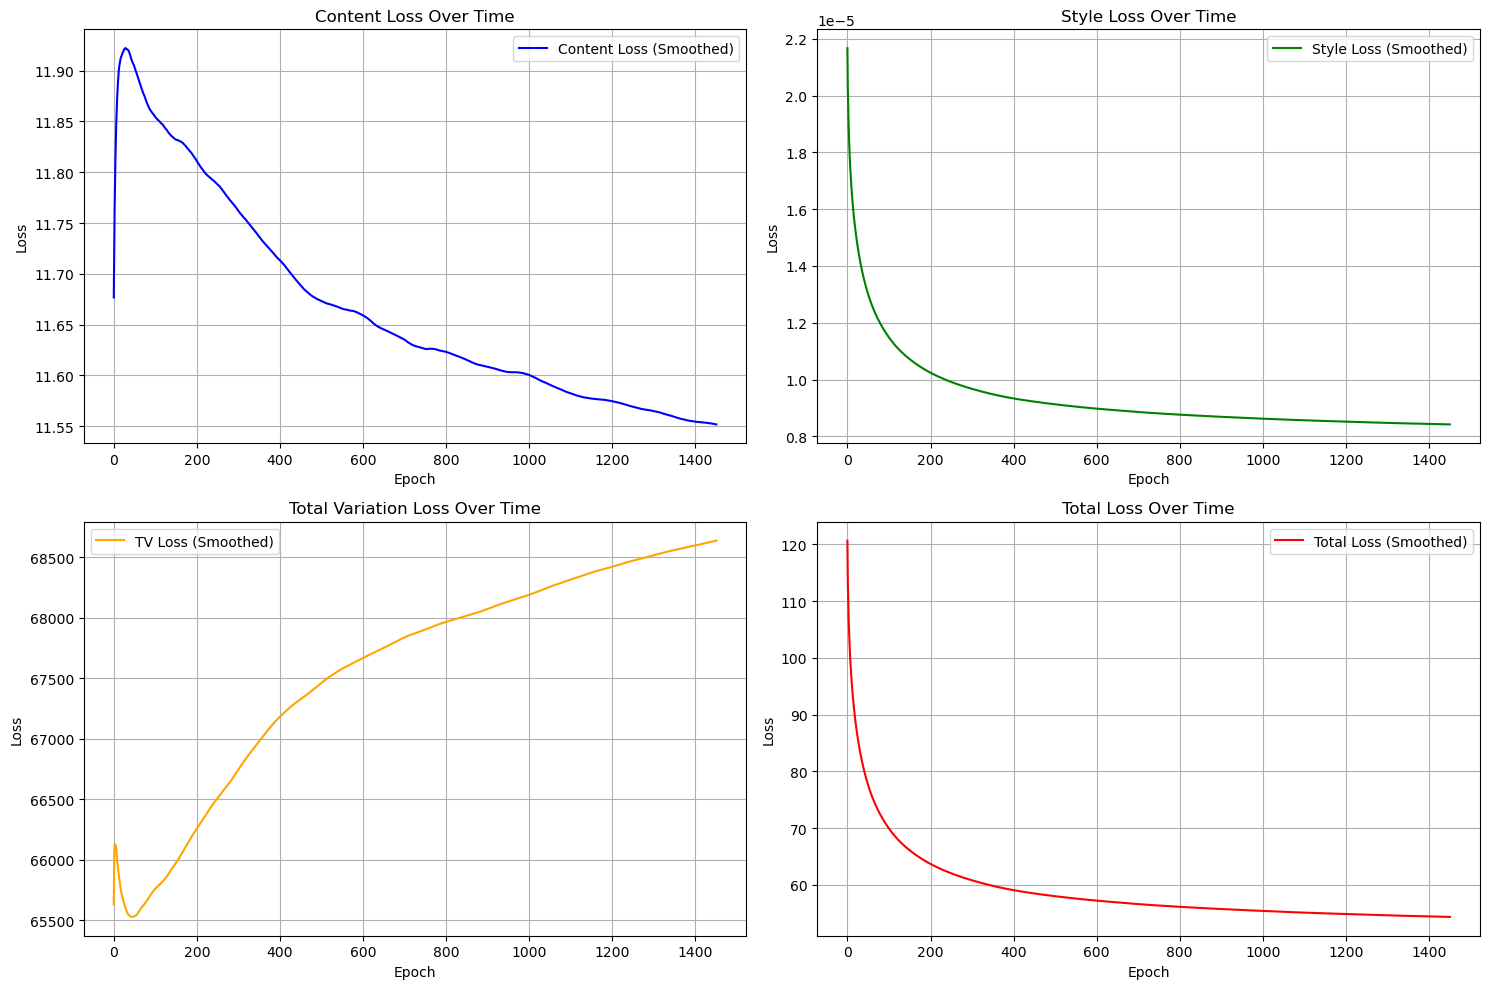

In [19]:
def moving_average(data, window_size=50):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

window_size = 50

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(moving_average(content_losses, window_size), label='Content Loss (Smoothed)', color='blue')
plt.title('Content Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(moving_average(style_losses, window_size), label='Style Loss (Smoothed)', color='green')
plt.title('Style Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(moving_average(tv_losses, window_size), label='TV Loss (Smoothed)', color='orange')
plt.title('Total Variation Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(moving_average(total_losses, window_size), label='Total Loss (Smoothed)', color='red')
plt.title('Total Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()